<font size="10">Discovering Conjugate Mappings: Conjugacy Between the Rossler Poincare Map and the Logistic map</font>

<font size="4">This notebook employs an autoencoder neural network structure ...</font>

<font size="4">This code was written by Jason J. Bramburger and accompanies the work in Section 6.5 of the book <i>Data-Driven Methods for Dynamic Systems</i>. We use Tensorflow 2.0 to build the neural network, which is imported as tf.

In [3]:
import tensorflow as tf
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [6]:
# Rossler right-hand-side
def Rossler(x,t,c = 18):
    a = 0.1
    b = 0.1
    
    dxdt = [-x[1] - x[2], x[0] + a*x[1], b + x[2]*(x[0] - c)]
    return dxdt

In [211]:
# Continuous-time simulation data

# Initializations
dt = .005
t_span = np.arange(0, 20000, dt)
x0 = [0, -15, 0] 
c = 18

# Solution data
xsol = []
xsol = odeint(Rossler, x0, t_span, args = (c,))

Text(0, 0.5, '$y(t)$')

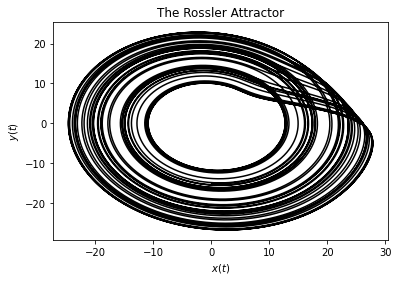

In [212]:
# Plot Rossler Solution (x_2 vs. x_1)

plt.plot(xsol[1:50000,0],xsol[1:50000,1],'k')
plt.title("The Rossler Attractor")
plt.xlabel("$x(t)$")
plt.ylabel("$y(t)$")

In [213]:
# Create section data
Psec = []
temp = [0]*len(xsol[:,1])
count = 0
for m in range(len(temp)-1):
    if xsol[m,0] <= 0 and xsol[m+1,0] >= 0: # section condition
        temp[count] = xsol[m+1,1] 
        count = count + 1
Psec.append(np.array(temp[1:count]))   

In [214]:
N = 1623
xn = np.zeros((N,1))
xnp1 = np.zeros((N,1))

for n in range(N):
    xn[n] = Psec[0][n]
    xnp1[n] = Psec[0][n+1]
    
#Scale data into [0,1]
max_xn = xn.max()
min_xn = xn.min()

slope = 1/(max_xn - min_xn)
yint = -slope*min_xn

# Print scaling terms
print(slope)
print(yint)

xn = slope*xn + yint
xnp1 = slope*xnp1 + yint

# Build input data matrix of forward iterates
forward_iters = 10
xnforward = []

xnp1 = xnp1[:-forward_iters] 
for j in range(forward_iters): 
    xnforward.append(xn[j:-forward_iters+j])

0.06734752269044327
1.791773357461594


Text(0, 0.5, '$y_{n+1}$')

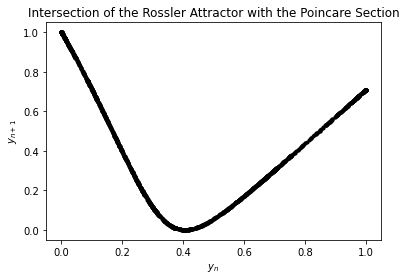

In [215]:
# Plot Rossler Section Data

# Plot the original Poincare section data
#plt.plot(Psec[0][:-1],Psec[0][1:],'k.') 

# Plot the scaled and shifted Poincare section data
plt.plot(xnforward[0],xnforward[1],'k.')

# Plot labels
plt.title("Intersection of the Rossler Attractor with the Poincare Section")
plt.xlabel("$y_n$")
plt.ylabel("$y_{n+1}$")

In [216]:
# Conjugacy neural network architecture

from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

class Conjugacy(Model):
  def __init__(self,
                 width = 100,
                 size_x = 1,
                 size_y = 1,
                 activation = 'selu',
                 steps = 1,
                 numblksIn = 1,
                 numblksOut = 1,
                 l1reg = 1e-15,
                 l2reg = 1e-15,
                 **kwargs):
    super(Conjugacy, self).__init__()
    self.width = width 
    self.size_x = size_x
    self.size_y = size_y
    self.activation = activation
    self.steps = steps
    self.numblksIn = numblksIn
    self.numblksOut = numblksOut
    self.l1reg = l1reg
    self.l2reg = l2reg
    self.initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)
    
    # Trainable network parameter
    self.c1 = tf.Variable(3.9661386, trainable = False)
    self.c2 = tf.Variable(-4.671839, trainable = False) 	
    
    # Encoder function
    self.encoder = tf.keras.Sequential()
    
    for n in range(self.numblksIn): #adding more layers
        self.encoder.add(layers.Dense(width, activation=self.activation, 
                                      kernel_initializer=self.initializer, 
                                      kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                      bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    self.encoder.add(layers.Dense(size_y, activation=self.activation, 
                                  kernel_initializer=self.initializer,
                                  kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                  bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))

    # Decoder function
    self.decoder = tf.keras.Sequential()
    
    for n in range(self.numblksOut): #adding more layers
        self.decoder.add(layers.Dense(width, activation=self.activation, 
                                      kernel_initializer=self.initializer, 
                                      kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                      bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    self.decoder.add(tf.keras.layers.Dense(size_y, activation= self.activation, 
                                           kernel_initializer=self.initializer, 
                                           kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                           bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    
  def call(self, x):
    encoded = self.encoder(x[0])
    encoded_p1 = self.c1*encoded + self.c2*tf.square(encoded)
    decoded = self.decoder(encoded_p1)
    
    # Conjugacy loss
    x_recon = self.decoder(encoded)
    self.add_loss(tf.reduce_mean(tf.math.square(x[0] - x_recon)))
    
    # Build loss function
    yn = encoded
    for s in range(self.steps):
        ynp1 = self.encoder(x[s+1])
        
        # Iteration loss in y
        y_step = self.c1*yn + self.c2*tf.square(yn) 
        self.add_loss((tf.reduce_mean(tf.math.square(ynp1 - y_step)))/self.steps)

        # Iteration loss in x
        xnp1 = self.decoder(y_step)
        self.add_loss((tf.reduce_mean(tf.math.square(x[s+1] - xnp1)))/self.steps)
 
        yn = y_step
    
    return decoded

In [223]:
# Neural Network Parameters

width = 100 # width of each NN layer
size_x = 1 # number of variables in the tent map
size_y = 1 # number of variables in the logistic map
activation = 'selu' # nonlinear activation function at each NN layer
steps = 1 # Number of steps for loss function
learning_rate = 0.00001
numblks_in = 3 # number of layers for the encoder NN
numblks_out = 3 # number of layers for the decoder NN

In [224]:
conjugacy = Conjugacy(width, size_x, size_y, activation, steps, numblks_in, numblks_out)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 100)

optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
conjugacy.compile(optimizer=optimizer, loss = 'mse') 

conjugacy.fit(xnforward, xnp1, callbacks = [callback], epochs = 100)

Epoch 1/100
51/51 [==============================] - 1s 2ms/step - loss: 0.7138
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 0.5496
Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 0.4304
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 0.3678
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.3284
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.2991
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.2720
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.2466
Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.2241
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 0.2019
Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 0.1829
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.1674
Epoch 13/100
51/51 [=================

In [226]:
# Check performance of trained neural network

# Print logistic variables
print(conjugacy.c1.numpy(), '\t * y')
print(conjugacy.c2.numpy(), '\t * y^2')
print('')

# Apply network components to the data
yn = conjugacy.encoder(xnforward[0])
xn_recon = conjugacy.decoder(yn)
ynp1 = conjugacy.c1*yn + conjugacy.c2*tf.square(yn)
xnp1_recon = conjugacy.decoder(ynp1)
ynp1_2 = conjugacy.encoder(xnp1)

# Print data results
# print(xnforward[0])
# print('')
# print(xn_recon.numpy())
# print('')
# print(xnp1)
# print('')
# print(xnp1_recon.numpy())

3.9661386 	 * y
-4.671839 	 * y^2



In [ ]:
# Save Results
#!mkdir -p saved_conjugacy_networks
#conjugacy.save('saved_conjugacy_networks/rossler_c=18')

Model: "conjugacy_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_74 (Sequential)  (None, 1)                 601       
                                                                 
 sequential_75 (Sequential)  (None, 1)                 601       
                                                                 
Total params: 1,204
Trainable params: 1,204
Non-trainable params: 0
_________________________________________________________________
3.9661386 	 * y
-4.671839 	 * y^2

[[4.11404976e-01]
 [5.89315757e-04]
 [9.99032088e-01]
 ...
 [4.65703176e-01]
 [2.56456709e-02]
 [9.31134235e-01]]

[[0.42093518]
 [0.01513866]
 [0.98510265]
 ...
 [0.478302  ]
 [0.02694053]
 [0.9264574 ]]

[[5.89315757e-04]
 [9.99032088e-01]
 [7.07931980e-01]
 ...
 [2.56456709e-02]
 [9.31134235e-01]
 [6.15335759e-01]]

[[0.00941108]
 [0.98615617]
 [0.7064474 ]
 ...
 [0.02104129]
 [0.9314026 ]
 [0.6114203 ]]


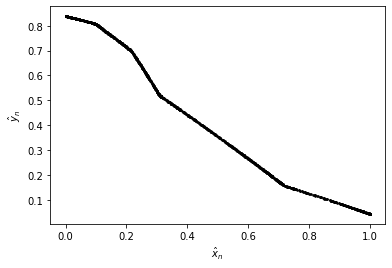

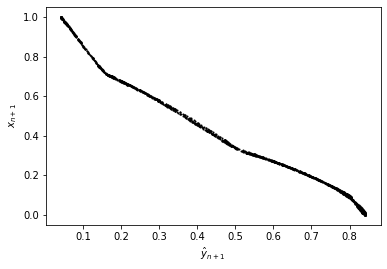

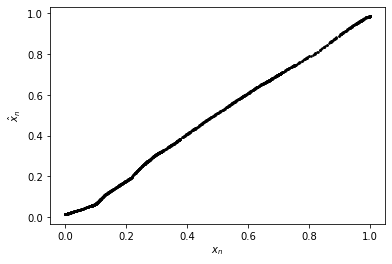

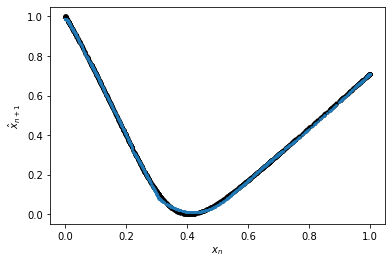

In [230]:
# Load in saved model
new_model = tf.keras.models.load_model('saved_conjugacy_networks/rossler_c=18')

# Check its architecture
new_model.summary()

print(new_model.c1.numpy(), '\t * y')
print(new_model.c2.numpy(), '\t * y^2')
print('')

yn = new_model.encoder(xnforward[0])
xn_recon = new_model.decoder(yn)
ynp1 = new_model.c1*yn + new_model.c2*tf.square(yn)
xnp1_recon = new_model.decoder(ynp1)
ynp1_2 = new_model.encoder(xnp1)

print(xnforward[0])
print('')
print(xn_recon.numpy())
print('')
print(xnp1)
print('')
print(xnp1_recon.numpy())

fig = plt.figure()
plt.plot(xnforward[0], yn, 'k.', markersize=3)
plt.xlabel('$\hat x_{n}$')
plt.ylabel('$\hat y_{n}$')

plt.show()

fig2 = plt.figure()
plt.plot(ynp1, xnp1, 'k.', markersize=2)
plt.xlabel('$\hat y_{n+1}$')
plt.ylabel('$ x_{n+1}$')

plt.show()

fig3 = plt.figure()
plt.plot(xnforward[0], xn_recon, 'k.', markersize=3)
plt.xlabel('$x_n$')
plt.ylabel('$\hat x_{n}$')

plt.show()

fig4 = plt.figure()
plt.plot(xnforward[0], xnp1,'k.')
plt.plot(xnforward[0], xnp1_recon, 'b.', markersize=3)
plt.xlabel('$x_n$')
plt.ylabel('$\hat x_{n+1}$')

plt.show()

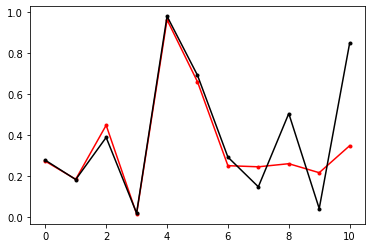

In [228]:
# Iterating the conjugacy mapping
iters = 10
start = 40 
ypred = [yn[start]] 
for i in range(iters):
    ypred.append(new_model.c1*ypred[i] + new_model.c2*tf.square(ypred[i]))

ypred = np.squeeze(ypred)              

xpred = new_model.decoder(ypred)
fig1 = plt.figure()
plt.plot(xn[start:start+iters+1],'r.-')
plt.plot(xpred,'k.-')